# Data Analysis
In this Jupyter Notebook, we analyze marine heatwave events from the last 40 years of CESM-LE simulations. In the notebook before this one, titled savingensembleruns_last40years.ipynb, we ran Ocetrac on the 100 CESM-LE simulations, setting a radius size 3. 

### Loading in packages

In [1]:
##### LOADING IN PACKAGES #--------------------------------------------------------------
import s3fs; import xarray as xr; import numpy as np
import pandas as pd; 
import dask.array as da
import ocetrac

import matplotlib.pyplot as plt; import cartopy.crs as ccrs

import warnings; import expectexception
warnings.filterwarnings('ignore')

import netCDF4 as nc; import datetime as dt
import scipy

import intake; import pprint
# Allow multiple lines per cell to be displayed without print (default is just last line)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Enable more explicit control of DataFrame display (e.g., to omit annoying line numbers)
from IPython.display import HTML

In [6]:
%matplotlib inline

### Loading marine heatwave event files and SST anomaly files

In [7]:
%%time
 
# Open original collection description file #----------------------------------------------
cat_url_orig = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
coll_orig = intake.open_esm_datastore(cat_url_orig)

CPU times: user 24.4 s, sys: 1.32 s, total: 25.7 s
Wall time: 26.9 s


In [8]:
%%time

subset = coll_orig.search(component='atm',variable='SST',frequency='month_1',experiment='historical')
filenamechange = list(subset.df.member_id.unique())

CPU times: user 965 ms, sys: 1.59 ms, total: 966 ms
Wall time: 1.02 s


In [9]:
%%time

list_of_xarrays = []
list_of_xarrays_SSTA = []

for i in filenamechange:
    
    string_head = '/glade/work/cassiacai/' + str(i) + '_rad3_blobs.nc'    
    xarray_file = xr.open_dataset(str(string_head))
    list_of_xarrays.append(xarray_file)
    
    string_head_SSTA = '/glade/work/cassiacai/' + str(i) + '_detrended.nc'
    xarray_file_SSTA = xr.open_dataset(str(string_head_SSTA))
    list_of_xarrays_SSTA.append(xarray_file_SSTA)

CPU times: user 1.52 s, sys: 396 ms, total: 1.92 s
Wall time: 10.9 s


In [10]:
%%time

concated_xarray = xr.concat(list_of_xarrays, "new_dim")

CPU times: user 4.25 s, sys: 11.4 s, total: 15.7 s
Wall time: 54.1 s


In [11]:
%%time

concated_xarray_SSTA = xr.concat(list_of_xarrays_SSTA, "new_dim")

CPU times: user 4.13 s, sys: 11.3 s, total: 15.5 s
Wall time: 36.2 s


### Combining SSTA and MHW event files

In [12]:
%%time

combined_xarray = xr.combine_by_coords([concated_xarray, concated_xarray_SSTA])
combined_xarray['SSTA'] = combined_xarray['__xarray_dataarray_variable__']
combined_xarray = combined_xarray.drop(['__xarray_dataarray_variable__'])

CPU times: user 3.7 ms, sys: 0 ns, total: 3.7 ms
Wall time: 3.7 ms


In [13]:
combined_xarray

<xarray.Dataset>
Dimensions:    (time: 481, lat: 192, lon: 288, new_dim: 100)
Coordinates:
  * time       (time) object 1975-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member_id  (new_dim) <U12 'r1i1001p1f1' 'r2i1021p1f1' ... 'r20i1301p1f2'
    quantile   float64 0.9
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: new_dim
Data variables:
    labels     (new_dim, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    SSTA       (new_dim, time, lat, lon) float64 0.0 0.0 ... -0.007121 -0.007111

### Setting our area of interest

In [9]:
# North Pacific latitude and longitude limits (currently, this is a small area)
lat_lim_less = 10. # 30. can change lat_lim_less to 10
lat_lim_great = 60.

lon_lim_less = 200.
lon_lim_great = 250.

In [10]:
%%time

combined_xarray_limited = combined_xarray.where((combined_xarray.lat >= lat_lim_less) & (combined_xarray.lat <= lat_lim_great) 
                        &(combined_xarray.lon >= lon_lim_less) & (combined_xarray.lon <= lon_lim_great),drop=True)

CPU times: user 9.59 s, sys: 8.68 s, total: 18.3 s
Wall time: 18.7 s


### Pre-processing 
#### Understanding what we are working with. How many MHW events are we working with?
Not necessary to run this part

In [ ]:
%%time 
no_mhw_counts = [] # how many MHW events globally?
for i in range(0,100):
    member_ = combined_xarray.isel(new_dim = i)
    event_member_ = member_.groupby(member_.labels)
    no_mhw_counts.append(len(event_member_))

In [2]:
# saving it here because the above code takes about 13 minutes to run
no_mhw_counts = [370, 349, 391, 360, 338, 330, 382, 354, 388, 323, 370, 173, 
                 422, 361, 359, 369, 372, 344, 358, 384, 428, 378, 337, 387, 
                 337, 380, 389, 396, 364, 319, 374, 343, 360, 398, 367, 372, 
                 381, 361, 397, 384, 387, 434, 359, 319, 377, 407, 336, 348, 
                 368, 340, 330, 423, 327, 403, 321, 380, 430, 374, 387, 360, 
                 377, 344, 390, 396, 381, 389, 363, 405, 388, 351, 369, 397, 
                 426, 325, 433, 351, 385, 406, 359, 383, 385, 387, 339, 366, 
                 430, 338, 366, 353, 442, 399, 389, 406, 374, 375, 453, 402, 
                 419, 415, 397, 401]

In [5]:
print('mean: ', np.nanmean(no_mhw_counts))
print('std:  ', np.std(no_mhw_counts))
print('max:  ', np.nanmax(no_mhw_counts))
print('min:  ', np.nanmin(no_mhw_counts))

mean:  374.13
std:   35.96877951779849
max:   453
min:   173


In [ ]:
%%time 
no_mhw_counts_lim_reg = [] # how many MHW events in our region of interest? How many different MHW events make any sort of appearance in our region?
for i in range(0,100):
    member_ = combined_xarray_limited.isel(new_dim = i)
    event_member_ = member_.groupby(member_.labels)
    no_mhw_counts_lim_reg.append(len(event_member_))

In [ ]:
# saving it here as well although the above cell takes less than 30 s to run
no_mhw_counts_lim_reg = [58, 47, 46, 41, 35, 40, 51, 54, 51, 42, 51, 19, 44, 
                         47, 48, 35, 44, 43, 47, 50, 54, 42, 42, 48, 33, 50, 
                         56, 50, 50, 26, 49, 42, 57, 50, 48, 44, 51, 42, 50, 
                         63, 48, 51, 44, 35, 46, 51, 40, 48, 46, 50, 42, 58, 
                         39, 47, 39, 44, 48, 45, 44, 44, 55, 45, 48, 47, 58, 
                         46, 49, 51, 48, 38, 56, 51, 51, 38, 51, 31, 39, 51, 
                         51, 53, 53, 45, 40, 42, 49, 40, 48, 46, 63, 46, 54, 
                         41, 53, 44, 66, 61, 55, 64, 55, 47]

In [ ]:
print('mean: ', np.nanmean(no_mhw_counts_lim_reg))
print('std:  ', np.std(no_mhw_counts_lim_reg))

### Processing

#### MHW descriptors:

    1. Time (when it begins, when it ends, duration)
    2. Location (latitudes and longitudes)
    3. SSTA (what does the temperature anomaly look like)

In [14]:
member_ = combined_xarray.isel(new_dim = 0) # trying one ensemble member

In [22]:
# member_.to_netcdf("member0_events.nc")

In [16]:
event_member_ = member_.groupby(member_.labels)

In [17]:
event_member_ # for this ensemble member, there are 370 groups

DatasetGroupBy, grouped over 'labels'
370 groups with labels 1.0, 2.0, 3.0, ..., 369.0, 370.0.

In [18]:
# ---- remember that y is lat and x is lon

t_time_list = []; t_lats = []; t_lons = []; labels_list = []
t_mean_SSTA = []; t_max_SSTA = []; t_min_SSTA = []; t_std_SSTA = []; t_sum_SSTA = []
t_centroid_list = []; t_com_coord_list = []; t_total_cell_area_list = []
t_full_SSTA = []
    
for l, ent in event_member_: # l is label, ent is the event's descriptors
    groupedby_by_time = ent.groupby(ent.time)
    print('Label: ', l)
    labels_list.append(l)
    
    time_list = []; lats_list = []; lons_list = []
    mean_SSTA = []; max_SSTA = []; min_SSTA = []; std_SSTA = []; sum_SSTA = []
    centroid_list = []; com_coord_list = []; total_cell_area_list = []
    SSTA_full = []
    
    for n, gro in groupedby_by_time: # n is the timestep, gro is that timestep's descriptors
        
        time_list.append(n)
        SSTA_full.append(gro.SSTA.values)
        mean_SSTA.append(np.nanmean(gro.SSTA))
        max_SSTA.append(np.nanmax(gro.SSTA))
        min_SSTA.append(np.nanmin(gro.SSTA))
        std_SSTA.append(np.std(gro.SSTA))
        sum_SSTA.append(np.nansum(gro.SSTA))
        
        # -------------------------- Spatial 
        lats = tuple(gro.lat.values); lats_list.append(lats)
        lons = tuple(gro.lon.values); lons_list.append(lons)
        coord_pairs = list(zip(lats, lons))
        
        centroid = np.mean(coord_pairs,axis= 0) # geometric mean
        centroid_list.append(centroid)
        
        SSTA_y = [gro.SSTA.item(c)*gro.lat.item(c) for c in np.arange(0, len(lats))]
        SSTA_x = [gro.SSTA.item(c)*gro.lon.item(c) for c in np.arange(0, len(lons))]
        total_SSTA = np.nansum(gro.SSTA)
        
        x_com = sum(SSTA_y)/total_SSTA # center of mass 
        y_com = sum(SSTA_x)/total_SSTA # center of mass
        
        com_coord = [x_com,y_com]
        com_coord_list.append(com_coord)
        
        y, x = zip(*coord_pairs)        
        dlon = [np.cos(y[c]*np.pi/180)*(111*.25) for c in np.arange(0, len(coord_pairs))]
        dlat = (111*.25) * np.ones(len(dlon))
        cell_area = [np.sum(dlon[c]*dlat[c]) for c in np.arange(0, len(coord_pairs))] # area
        total_cell_area = np.sum(cell_area)
        total_cell_area_list.append(total_cell_area)
        
    t_time_list.append(time_list)
    t_lats.append(lats_list)
    t_lons.append(lons_list)
    
    t_full_SSTA.append(SSTA_full)
    t_mean_SSTA.append(mean_SSTA)
    t_max_SSTA.append(max_SSTA)
    t_min_SSTA.append(min_SSTA)
    t_std_SSTA.append(std_SSTA)
    t_sum_SSTA.append(sum_SSTA)
    t_centroid_list.append(centroid_list)
    t_com_coord_list.append(com_coord_list)
    t_total_cell_area_list.append(total_cell_area_list)

Label:  1.0
Label:  2.0
Label:  3.0
Label:  4.0
Label:  5.0
Label:  6.0
Label:  7.0
Label:  8.0
Label:  9.0
Label:  10.0
Label:  11.0
Label:  12.0
Label:  13.0
Label:  14.0
Label:  15.0
Label:  16.0
Label:  17.0
Label:  18.0
Label:  19.0
Label:  20.0
Label:  21.0
Label:  22.0
Label:  23.0
Label:  24.0
Label:  25.0
Label:  26.0
Label:  27.0
Label:  28.0
Label:  29.0
Label:  30.0
Label:  31.0
Label:  32.0
Label:  33.0
Label:  34.0
Label:  35.0
Label:  36.0
Label:  37.0
Label:  38.0
Label:  39.0
Label:  40.0
Label:  41.0
Label:  42.0
Label:  43.0
Label:  44.0
Label:  45.0
Label:  46.0
Label:  47.0
Label:  48.0
Label:  49.0
Label:  50.0
Label:  51.0
Label:  52.0
Label:  53.0
Label:  54.0
Label:  55.0
Label:  56.0
Label:  57.0
Label:  58.0
Label:  59.0
Label:  60.0
Label:  61.0
Label:  62.0
Label:  63.0
Label:  64.0
Label:  65.0
Label:  66.0
Label:  67.0
Label:  68.0
Label:  69.0
Label:  70.0
Label:  71.0
Label:  72.0
Label:  73.0
Label:  74.0
Label:  75.0
Label:  76.0
Label:  77.0
Label:  

In [17]:
### -------------------- my lists (keeping track of all my lists from the loop above here
# t_time_list
# t_lats
# t_lons
# labels_list
# t_full_SSTA
# t_mean_SSTA
# t_max_SSTA
# t_min_SSTA
# t_std_SSTA
# t_sum_SSTA
# t_centroid_list
# t_com_coord_list
# t_total_cell_area_list

### Analysis

Notes
- PCA --> order them by calendar month (starting calendar month)
- if I see a pattern --> pattern tracking --> similarity --> Gulf Stream

Ideas
- How many grid points are not near a mhw?
- For each timestep, we can look at the maximum and minimum longitudes and latitudes for extent information (caveat: wrap-around MHWs)
- Create a metric for the shape (can look at the perimeter and area. Can do perimeter / area)

In [17]:
ensemble0_data = pd.DataFrame(list(zip(t_time_list, t_lats, t_lons,
                            labels_list, t_full_SSTA, t_mean_SSTA,
                            t_max_SSTA, t_min_SSTA, t_std_SSTA, 
                            t_sum_SSTA, t_centroid_list, t_com_coord_list,
                            t_total_cell_area_list)), 
                    columns = ['t_time_list', 't_lats', 't_lons',
                              'labels_list', 't_full_SSTA', 't_mean_SSTA',
                              't_max_SSTA', 't_min_SSTA', 't_std_SSTA',
                              't_sum_SSTA', 't_centroid_list', 't_com_coord_list',
                              't_total_cell_area_list'])

In [19]:
ensemble0_data.to_pickle("ensemble0_data.pkl")

In [3]:
output = pd.read_pickle("ensemble0_data.pkl")

In [19]:
from sklearn.decomposition import PCA
import hoggorm as ho # https://hoggorm.readthedocs.io/en/latest/matrix_corr_coeff.html
from scipy import sparse # in case we want to create a sparse matrix 
from numpy.linalg import norm # for the cosine similarity step
from scipy import signal # in case we want to use signal.correlate

In [20]:
ending_val = 15

In [21]:
member_

<xarray.Dataset>
Dimensions:    (time: 481, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 1975-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member_id  <U12 'r1i1001p1f1'
    quantile   float64 0.9
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12 1
Data variables:
    labels     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SSTA       (time, lat, lon) float64 0.0 0.0 0.0 ... -0.0154 -0.01539

In [20]:
%%time
mhw_event_SSTA_gridded = [] 

for i in range(1,ending_val): #371 is the total number for the first
    mhw_id = i
    mhw_event_rel = member_.where(member_.labels==mhw_id, drop=False)   # dimensions are (481, 192, 288) --> (time, lat, lon)
    # mhw_event_rel = member_.where(member_.labels==mhw_id, drop=True)  # if drop = True, then dimensions will now be different
    mhw_event_SSTA_gridded.append(mhw_event_rel.SSTA)

CPU times: user 910 ms, sys: 853 ms, total: 1.76 s
Wall time: 1.83 s


In [21]:
print(len(mhw_event_SSTA_gridded))

14


In [22]:
%%time
# -------------------------------------------
# Convert SSTA to 1 and all nan to 0.
# -------------------------------------------
full_use_grids = []

for i in range(0, ending_val-1):
    x = mhw_event_SSTA_gridded[i][:,:,:]
    no_nans_x = np.nan_to_num(x) # replace all nans with zeroes
    # np.unique(no_nans_x[0]) 
    no_nans_x[no_nans_x != 0] = 1 # replace all SSTA values with 1 (for shape comparison)
    full_use_grids.append(no_nans_x)
    # np.unique(no_nans_x[0]) # check it
    # print(no_nans_x.shape) # check it

CPU times: user 3.11 s, sys: 572 ms, total: 3.68 s
Wall time: 3.72 s


In [23]:
# -------------------------------------------
# Let's find which timesteps have a MHW.
# -------------------------------------------
example_identifier = 4

example_MHW = full_use_grids[example_identifier].max(axis=(1,2)) 
# print(example_MHW)
timeswithMHW = np.where(example_MHW == 1)
print(timeswithMHW)
print(len(timeswithMHW[0]))

# for i in range(len(result[0])):
#     print(result[0][i])

(array([ 9, 10]),)
2


In [24]:
# -------------------------------------------
# Let's reshape our data so that we can use 
# in our Principal Component Analysis.
# -------------------------------------------
print(full_use_grids[0].shape) # let's check if our grid is the right shape
full_use_grids_asarray = np.asarray(full_use_grids)
print(full_use_grids_asarray.shape)
reshaped = full_use_grids_asarray.reshape(ending_val-1,-1)
print(reshaped.shape)

(481, 192, 288)
(14, 481, 192, 288)
(14, 26597376)


In [34]:
######### ------ Principal Component Analysis
# -------------------------------------------
from sklearn.preprocessing import MinMaxScaler # allows you to set the variance that is supposed to be explained by the generated components.
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(reshaped)

# 95% of variance
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

PCA(n_components=0.95)

In [60]:
components = pca.components_
print(components[:,:].shape)
number_components = np.asarray(components[:,:].shape)[0]
print(number_components)

(6, 26597376)
6


In [36]:
nuclear_norm = np.linalg.norm(pca.singular_values_) # is the sum of singular singulars
sv_scaled = pca.singular_values_**2/(nuclear_norm**2) 
# sv_scaled = pca.explained_variance_ratio_
sv_total = np.cumsum(pca.singular_values_**2)/(nuclear_norm**2)

<AxesSubplot:>

Text(0.5, 0, 'PCA component')

Text(0, 0.5, 'explained variance ratio')

<AxesSubplot:>

Text(0.5, 0, 'PCA component')

Text(0, 0.5, 'cumulatiave explained variance ratio')

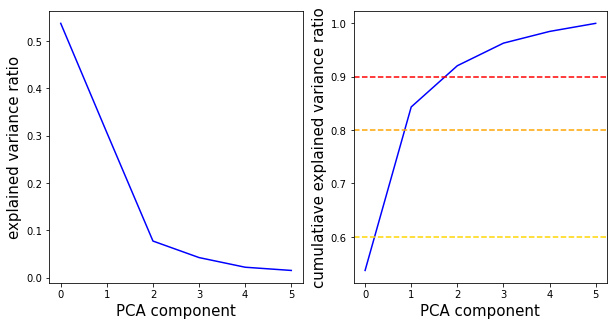

In [46]:
# -- Plot the singular values
plt.rcParams["figure.figsize"] = (25,6)

plt.rcParams["figure.figsize"] = (10,5)

plt.subplot(1, 2, 1)
plt.plot(sv_scaled, 'blue') # equivalent to pca.explained_variance_ratio_
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('explained variance ratio', fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(sv_total, 'blue')
plt.axhline(y=0.60,color='black',linestyle = '--',c='gold')
plt.axhline(y=0.80,color='black',linestyle = '--', c='orange')
plt.axhline(y=0.90,color='black',linestyle = '--',c='red')
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)

plt.show()

In [62]:
np.asarray(components[:number_components,:]).shape
reshaped_components = pca.components_.reshape((number_components, 481, 192, 288))
reshaped_components.shape

(6, 26597376)

(6, 481, 192, 288)

(481,)

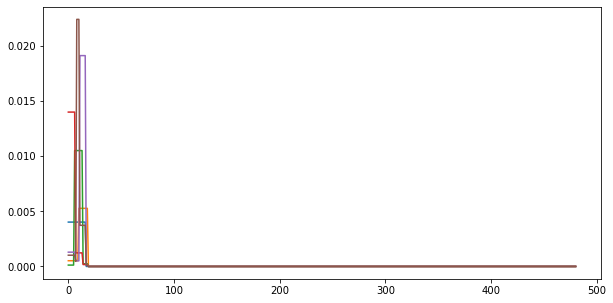

In [86]:
example_MHW = reshaped_components[0].max(axis=(1,2)) 
example_MHW.shape
plt.plot(np.arange(0,481), reshaped_components[0].max(axis=(1,2)) )
plt.plot(np.arange(0,481), reshaped_components[1].max(axis=(1,2)) )
plt.plot(np.arange(0,481), reshaped_components[2].max(axis=(1,2)) )
plt.plot(np.arange(0,481), reshaped_components[3].max(axis=(1,2)) )
plt.plot(np.arange(0,481), reshaped_components[4].max(axis=(1,2)) )
plt.plot(np.arange(0,481), reshaped_components[5].max(axis=(1,2)) )


In [77]:
example_identifier = 5

example_MHW = reshaped_components[example_identifier].max(axis=(1,2)) 
# example_MHW
# print(example_MHW)
timeswithMHW = np.where(example_MHW != 0)
print(timeswithMHW)
print(len(timeswithMHW[0]))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]),)
19


In [ ]:
fig, axs = plt.subplots(24,5, figsize=(18, 72), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .3, wspace=.3)

axs = axs.ravel()

for i in range(end_time_index-begin_time_index):
    mhw_event_slice = mhw_event_rel.__xarray_dataarray_variable__[begin_time_index+i,:,:]
    mhw_event_slice = mhw_event_rel.__xarray_dataarray_variable__[begin_time_index+i,:,:]
    axs[i].imshow(mhw_event_slice, vmin=0,vmax=5)
    axs[i].add_patch(Rectangle((lon_lim_less, lat_lim_less), lon_lim_great - lon_lim_less, lat_lim_great-lat_lim_less,facecolor='None', edgecolor='red'))
    axs[i].set_title(str(begin_time_index+i),fontsize=15)

In [48]:
saving = pca.fit_transform(reshaped)

In [49]:
saving # what do these coordinates mean

array([[-1.65898951e+01, -1.71856555e+01, -1.58792561e+01,
         6.26463855e+01,  3.00188185e+00,  1.63283166e+00],
       [ 2.28483166e+02,  1.67899416e+01,  1.00429800e+00,
         4.22509382e-01,  1.30584559e-01,  9.00433217e-02],
       [-1.79467865e+01, -2.00448043e+01,  8.58338638e+01,
         5.50448787e+00,  1.17725524e+00,  7.39595650e-01],
       [-1.56544906e+01, -1.54445959e+01, -8.19986169e+00,
        -8.69573148e+00, -1.33468145e+01,  3.58830743e+01],
       [-1.53785930e+01, -1.49622917e+01, -7.10636016e+00,
        -6.38290241e+00, -4.88381656e+00, -6.32392787e+00],
       [-3.98250624e+01,  1.70675166e+02,  1.94974474e+00,
         7.72394996e-01,  2.31625147e-01,  1.58224433e-01],
       [-1.58682181e+01, -1.58276322e+01, -9.27087247e+00,
        -1.19452769e+01,  4.43465856e+01,  5.96986323e+00],
       [-1.52860621e+01, -1.48035132e+01, -6.79512212e+00,
        -5.84861719e+00, -4.01040755e+00, -4.50423394e+00],
       [-1.54580881e+01, -1.50998838e+01, -7.394

In [ ]:
# 2 and 6

def plot_digits(XX, N):  #def plot_digits(XX, N, title): 
    """Small helper function to plot N**2 digits."""
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    for i in range(N):
        for j in range(N):
            ax[i,j].imshow(XX[(N)*i+j,:].reshape((16, 16)), cmap="Greys")
            ax[i,j].axis("off")
            # fig.suptitle(title, fontsize=24)

# plot_digits(X_train, 8, "First 64 Training Features" )
plot_digits(X_train, 8)
plt.savefig('first64_training_features.pdf')

print(Y_train[0:8**2])

plot_digits(components[:16,:], 4)
plt.savefig('task1fig2.pdf')

In [ ]:
plt.imshow(full_use_grids[2][0,:,:])

In [ ]:
plt.imshow(full_use_grids[2][1,:,:])

In [ ]:
plt.imshow(full_use_grids[5][9,:,:])

In [ ]:
plt.imshow(full_use_grids[8][12,:,:])

In [ ]:
# center it
# image registration (look through!)

In [ ]:
temp_array = full_use_grids[8].max(axis=(1,2))
print(temp_array)

In [ ]:
plt.scatter(saving[:,0], saving[:,1],alpha=0.5)
plt.xlim(-20,-10)
plt.ylim(-20,-10)

In [ ]:
# variance --> explained variance
# EOF space -- application

In [ ]:
pca.components_.shape

In [ ]:
reshaped_components = pca.components_.reshape((2, 481, 192, 288))

In [ ]:
reshaped_components.shape # two most representative heatwaves

In [ ]:
plt.imshow(reshaped_components[0,0,:,:])

In [ ]:
plt.imshow(reshaped_components[0,1,:,:])

In [ ]:
plt.imshow(reshaped_components[0,2,:,:])

In [ ]:
plt.imshow(reshaped_components[0,3,:,:])

In [ ]:
plt.imshow(reshaped_components[0,4,:,:])

In [ ]:
plt.imshow(reshaped_components[0,5,:,:])

In [ ]:
plt.imshow(reshaped_components[0,6,:,:])

In [ ]:
plt.imshow(reshaped_components[0,7,:,:])

In [ ]:
plt.imshow(reshaped_components[0,8,:,:])

In [ ]:
plt.imshow(reshaped_components[0,9,:,:])

In [ ]:
plt.imshow(reshaped_components[0,10,:,:])

In [ ]:
plt.imshow(reshaped_components[0,11,:,:])

In [ ]:
plt.imshow(reshaped_components[0,12,:,:])

In [ ]:
trying = reshaped_components[0].max(axis=(1,2)) 
print(trying)

In [ ]:
trying = reshaped_components[1].max(axis=(1,2)) 
print(trying)

In [ ]:
plt.imshow(reshaped_components[1,0,:,:],cmap=plt.get_cmap('gray'))

In [ ]:
plt.imshow(reshaped_components[1,1,:,:],cmap=plt.get_cmap('gray'))

In [ ]:
plt.imshow(reshaped_components[1,2,:,:],cmap=plt.get_cmap('gray'))

In [ ]:
plt.imshow(reshaped_components[1,3,:,:])

In [ ]:
plt.imshow(reshaped_components[1,4,:,:])

In [ ]:
plt.imshow(reshaped_components[1,5,:,:])

In [ ]:
plt.imshow(reshaped_components[1,6,:,:])

In [ ]:
plt.imshow(reshaped_components[1,7,:,:])

In [ ]:
plt.imshow(reshaped_components[1,8,:,:])

In [ ]:
# 0 is not here

only_longer_mhws = []
for i in range(0, ending_val):
    temp_array = full_use_grids[i].max(axis=(1,2)) 
    which_months = np.where(new_array_1 == 1)
    
    temp_list = []
    if np.count_nonzero(temp_array == 1) > 1:
        temp_list = []
        for j in range(len(which_months[0])):
            val = which_months[0][j]
            temp_list.append(full_use_grids[i][j,:,:]) # make this faster
        # only_longer_mhws.append(full_use_grids[i])
        only_longer_mhws.append(temp_list)

In [ ]:
print(len(only_longer_mhws))

In [ ]:
print(len(only_longer_mhws[0]))

In [ ]:
plt.imshow(only_longer_mhws[0][0])

In [ ]:
plt.imshow(only_longer_mhws[5][0])

In [ ]:
plt.imshow(full_use_grids[1][0,:,:])

In [ ]:
# full_use_grids[0]

In [ ]:
# -------------------- processing
x = mhw_event_SSTA_gridded[1][:,:,:]
no_nans_x = np.nan_to_num(x) # replace all nans with zeroes
# np.unique(no_nans_x[0]) 

no_nans_x[no_nans_x != 0] = 1 # replace all SSTA values with 1 (for shape comparison)
# np.unique(no_nans_x[0]) # check it
print(no_nans_x.shape) # check it

In [ ]:
corr = signal.correlate(no_nans_x[0:8,:,:], no_nans_x_1[10:18], mode='same')
corr /= np.max(corr)
corr.shape
plt.imshow(corr[1,:,:])

In [ ]:
no_nans_x

In [ ]:
x_1 = mhw_event_SSTA_gridded[5][:,:,:]
no_nans_x_1 = np.nan_to_num(x_1) # replace all nans with zeroes
# np.unique(no_nans_x[0]) 

no_nans_x_1[no_nans_x_1 != 0] = 1 # replace all SSTA values with 1 (for shape comparison)
# np.unique(no_nans_x[0]) # check it
print(no_nans_x_1.shape) # check it

In [ ]:
np.allclose(np.linalg.norm(no_nans_x), np.sqrt(np.sum(np.square(no_nans_x)))) 

In [ ]:
distance = np.linalg.norm(no_nans_x[0,:,:] - no_nans_x_1[10,:,:]) # need to understand this more # check degrees here #l2 norm maybe not # maybe area
print(distance)

In [ ]:
plt.imshow(no_nans_x[0,:,:])

In [ ]:
plt.imshow(no_nans_x_1[10,:,:])

In [ ]:
distance = np.linalg.norm(no_nans_x[0,:,:] - no_nans_x_1[10,:,:]) # need to understand this more # check degrees here 
print(distance)

# another way to calcualte some kind of shape similarity # calcualte lengths of the boundary

# fastdtw for marine heatwaves with different lengths (try later today code below)... 

In [ ]:
%%time

no_nans_x.max(axis=(1,2))

In [ ]:
%%time

no_nans_x_1.max(axis=(1,2))

In [ ]:
no_nans_x_1[11,:,:]

In [ ]:
plt.imshow(no_nans_x_1[10,:,:])

In [ ]:
plt.imshow(no_nans_x_1[11,:,:])

In [ ]:
plt.imshow(no_nans_x_1[12,:,:])

In [ ]:
plt.imshow(no_nans_x_1[13,:,:])

In [ ]:
plt.imshow(no_nans_x[1,:,:])

In [ ]:
plt.imshow(no_nans_x[2,:,:])

In [ ]:
plt.imshow(no_nans_x[3,:,:])

In [ ]:
plt.imshow(no_nans_x[4,:,:])

In [ ]:
plt.imshow(no_nans_x[5,:,:])

In [ ]:
plt.imshow(no_nans_x[6,:,:])

In [ ]:
# -------------------- trying a sprase matrix
# X_csr_a = sparse.csr_matrix(no_nans_x[0])
# X_csr_b = sparse.csr_matrix(no_nans_x[1])

# X_csc_a = sparse.csc_matrix(no_nans_x[0]) # compressed column matrix
# X_csc_b = sparse.csc_matrix(no_nans_x[1])

In [ ]:
rv_results = ho.RVcoeff([no_nans_x[0], no_nans_x[1],no_nans_x[2],no_nans_x[3],no_nans_x[4],no_nans_x[5], no_nans_x[6]])

print(rv_results[0, 1])
print(rv_results[1, 2])
print(rv_results[2, 3])
print(rv_results[3, 4])
print(rv_results[4, 5])
print(rv_results[5, 6])

In [ ]:
rv_results[0]

In [ ]:
plt.imshow(rv_results)
plt.colorbar()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

a = np.random.random((3, 10))
b = np.random.random((3, 10))
print(a.shape)
# Create sparse matrices, which compute faster and give more understandable output
# a_sparse, b_sparse = sparse.csr_matrix(a), sparse.csr_matrix(b)

# sim_sparse = cosine_similarity(a_sparse, b_sparse, dense_output=False)
# print(sim_sparse)

In [ ]:
# -------------------- cosine similarity

# Cosine similarity is a metric used to measure how
# similar the documents are irrespective of their size.
# Mathematically, it measures the cosine of the angle
# between two vectors projected in a multi-dimensional
# space.

# The cosine similarity is advantageous because even if
# the two similar documents are far apart by the Euclidean
# distance (due to the size of the document), chances are
# they may still be oriented closer together. The smaller
# the angle, higher the cosine similarity.

# -----------------------------------------------------

A = no_nans_x[0]
B = no_nans_x[1]

cosine = np.sum(A*B, axis=1)/(norm(A, axis=1)*norm(B, axis=1))
#

In [ ]:
# generating a sparse matrix
one_grid = mhw_event_SSTA_gridded[0].values
print(len(one_grid))
print(len(one_grid[0]))
one_grid
# print(len(one_grid[0]))
# for i in one_grid[0]:
#     np.isfinite(i)
# one_grid[0][one_grid[0] == 'nan'] = 0
# one_grid[0]
# X[X < 0.7] = 0

In [ ]:
nonantime_grids = []
for m in range(0, 14):
    intermediate_grids = []
    for i in range(0,481):
        unique_vals = np.unique(mhw_event_SSTA_gridded[m][i,:,:])    
        if len(unique_vals) > 1:
            intermediate_grids.append(mhw_event_SSTA_gridded[m][i,:,:].values)
    nonantime_grids.append(np.asarray(intermediate_grids))

In [ ]:
nonantime_grids[0][0] #.values

In [ ]:
arrayednonantime_grids = np.asarray(nonantime_grids)

In [ ]:
arrayednonantime_grids[0].reshape(len(arrayednonantime_grids[0]), 192*288)

In [ ]:
print(len(reshaped_arrayednonantime_grids[0]))

In [ ]:
# reshaping my arrays (flattening them so that they are 2 dimensional)
reshaped_arrayednonantime_grids = []
for i in range(len(arrayednonantime_grids)):
    reshaped_arrayednonantime_grids.append(arrayednonantime_grids[i].reshape(len(arrayednonantime_grids[i]), 192*288))

In [ ]:
reshaped_arrayedfull_grids = []
for i in range(len(mhw_event_SSTA_gridded)):
    reshaped_arrayedfull_grids.append(mhw_event_SSTA_gridded[i].reshape(len(mhw_event_SSTA_gridded[i]), 192*288))

In [ ]:
for i in range(len(arrayednonantime_grids)):
    print(reshaped_arrayednonantime_grids[i].shape)
print('')
for i in range(len(reshaped_arrayedfull_grids)):
    print(reshaped_arrayedfull_grids[i].shape)

In [ ]:
### trying to calculate similarity
# t_time_list
# t_lats
# t_lons
# labels_list
# t_full_SSTA
# t_mean_SSTA
# t_max_SSTA
# t_min_SSTA
# t_std_SSTA
# t_sum_SSTA
# t_centroid_list
# t_com_coord_list
# t_total_cell_area_list

In [ ]:
print(len(t_lats[0][1]))
print(len(t_lons[0][1]))

In [ ]:
t_lats[1][1]

In [ ]:
#### calculate similarity (cosine similarity)
#### import tensorflow as tf

# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
# a = mhw_event_SSTA_gridded[0]
# b = mhw_event_SSTA_gridded[1]
# # c = np.empty([15000, 24])

# # Make an array with the rows of a and same for b
# a_splitted=np.split(a, a.shape[0], 0)
# b_splitted=np.split(b, b.shape[0], 0)
# i=0
# for alpha in a_splitted:
#     for beta in b_splitted:
# #         # Gives a 4x6 matrix
#         sim=cosine_similarity(alpha[0],beta[0])
# #         print(sim)
#         # c[i,:]=sim.ravel()
# #         i+=1

### Continue here

In [ ]:
clustering = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0).fit(distance_matrix)

In [ ]:
plt.imshow(mhw_event_rel_true_drop.SSTA[0,:,:])
plt.show()
# plt.imshow(mhw_event_rel_true_drop.SSTA[1,:,:])
# plt.show()
# plt.imshow(mhw_event_rel_true_drop.SSTA[2,:,:])
# plt.show()
# plt.imshow(mhw_event_rel_true_drop.SSTA[3,:,:])
# plt.show()
# plt.imshow(mhw_event_rel_true_drop.SSTA[4,:,:])
# plt.show()
# plt.imshow(mhw_event_rel_true_drop.SSTA[5,:,:])
# plt.show()
# plt.imshow(mhw_event_rel_true_drop.SSTA[6,:,:])
# plt.show()

In [ ]:
xi = np.arange(0,360,0.25)
yi = np.arange(-90,90,0.9424083769633569)
x, y = np.meshgrid(xi, yi)

zi = mlab.griddata(x,y,t_full_SSTA[0][6],xi,yi)


In [ ]:
new_time_list = []

for i in range(len(t_time_list)):
    new_t_list = list(np.arange(0,len(t_time_list[i])))
    zipped = list(zip(new_t_list, t_total_cell_area_list[i]))
    new_time_list.append(zipped)

In [ ]:
# dynamic time warping

# d = {} # dictionary figure this out (how to index)
distances_i = []
for i in range(len(new_time_list)):
    distance_j = []
    for j in range(len(new_time_list)):
        distance, path = fastdtw(new_time_list[i], new_time_list[j], dist=euclidean)
        # d[(i, j)] = distance
        distance_j.append(distance)
    distances_i.append(distance_j)

In [ ]:
distance_matrix = np.array(distances_i)
X = distance_matrix

In [ ]:
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
X_transformed = embedding.fit_transform(X)
X_transformed.shape

In [ ]:
x_axis = X_transformed[:,0]
y_axis = X_transformed[:,1]

In [ ]:
annotations=np.arange(0,14)

plt.scatter(x_axis, y_axis, c=clustering.labels_)
for i, label in enumerate(annotations):
    plt.annotate(label, (x_axis[i], y_axis[i]))
plt.show()

In [ ]:
# find a way to show labels
# blob_id 3
# blob_id 13

# go and check the distances first -->

In [ ]:
mhw_id = 6.
mhw_event_rel = member_.where(member_.labels==mhw_id, drop=False)
mhw_event_rel_true_drop = member_.where(member_.labels==mhw_id, drop=True) # remove the drop so that now I would have a data cube

In [ ]:
mhw_event_rel_true_drop

In [ ]:
new_time_list[1]

new_time_list[5]

In [ ]:
# PCA --> order them by actual calendar month -
# if I see a pattern --> pattern tracking --> similarity --> Gulf Stream

In [ ]:
plt.imshow(mhw_event_rel_true_drop.SSTA[0,:,:])
plt.show()
plt.imshow(mhw_event_rel_true_drop.SSTA[1,:,:])
plt.show()
plt.imshow(mhw_event_rel_true_drop.SSTA[2,:,:])
plt.show()
plt.imshow(mhw_event_rel_true_drop.SSTA[3,:,:])
plt.show()
plt.imshow(mhw_event_rel_true_drop.SSTA[4,:,:])
plt.show()
plt.imshow(mhw_event_rel_true_drop.SSTA[5,:,:])
plt.show()
plt.imshow(mhw_event_rel_true_drop.SSTA[6,:,:])
plt.show()

In [ ]:
mhw_id = 5.
mhw_event_rel = member_.where(member_.labels==mhw_id, drop=False)
mhw_event_rel_true_drop = member_.where(member_.labels==mhw_id, drop=True)

In [ ]:
mhw_event_rel_true_drop

In [ ]:
plt.imshow(mhw_event_rel_true_drop.SSTA[0,:,:])
plt.show()
plt.imshow(mhw_event_rel_true_drop.SSTA[1,:,:])
plt.show()

In [ ]:
clustering = SpectralClustering(n_clusters=3, assign_labels='discretize', affinity='precomputed', random_state=0).fit(distance_matrix)

In [ ]:
clustering.labels_

In [ ]:
plt.scatter(x[:,0], x[:,1], c=clustering.labels_)
plt.show() 

In [ ]:
# function --> create some kind of gif to scan through the clusters

In [ ]:
# clustering
from sklearn.cluster import SpectralClustering
d

In [ ]:
a_zip = list(zip(list(np.arange(0,len(t_time_list[0]))), t_total_cell_area_list[0]))
b_zip = list(zip(list(np.arange(0,len(t_time_list[1]))), t_total_cell_area_list[1]))

In [ ]:
# dynamic time warping
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

distance, path = fastdtw(a_zip, b_zip, dist=euclidean)
print(distance)
print(path)

# run this function over all pairs 
# using these distances to do clustering --> new measure of similarity
# put into array

In [ ]:
help(fastdtw)

In [ ]:
mhw_id = 2285.
mhw_event_rel = combined_rel.where(combined_rel.labels==mhw_id, drop=False)
mhw_event_rel_true_drop = combined_rel.where(combined_rel.labels==mhw_id, drop=True)

In [ ]:
ent_full = []  
for l, ent in event_member_:

In [ ]:
file = event_NEP

label_ls = []; time_begin_ls = []; time_end_ls = []; duration_ls = []; 
intense_mean = []; intense_max = []; intense_min = [];intense_cumu = []
coords_ls = []; cell_area_ls = []; lat_ls = []; lon_ls = []

for l, ent in file:        
    label_ls.append(l)
    groupedby_by_time = ent.groupby(ent.time)
    time_begin = str(ent.time[0].values); time_begin_ls.append(time_begin)
    time_end = str(ent.time[-1].values); time_end_ls.append(time_end)
        
    duration = len(ent.groupby("time")); duration_ls.append(duration)

    temp_intense_mean = []; temp_intense_max = []; temp_intense_min = []; temp_intense_cumu = []
    temp_coords = []; temp_cell_area = []; temp_lat = []; temp_lon = []
    for n, gro in groupedby_by_time:
        lat = gro.lat.values
        lon = gro.lon.values
        time = gro.time.values
                        
        intensity_mean_val = gro['SST'].values.mean(); temp_intense_mean.append(intensity_mean_val)
        intensity_max_val = gro['SST'].values.max(); temp_intense_max.append(intensity_max_val)
        intensity_min_val = gro['SST'].values.min(); temp_intense_min.append(temp_intense_min)
        intensity_cumulative_val = gro['SST'].values.sum(); temp_intense_cumu.append(intensity_cumulative_val)

        coords = list(zip(lat, lon)); temp_coords.append(coords)
        temp_lat.append(lat); temp_lon.append(lon)
        y,x=zip(*coords)
        dlon = [np.cos(y[c]*np.pi/180)*(111.320*1) for c in np.arange(0, len(coords))]
        dlat = (110.574 *1) * np.ones(len(dlon))
        cell_area = [np.sum(dlon[c]*dlat[c]) for c in np.arange(0, len(coords))]; temp_cell_area.append(np.sum(cell_area))

    intense_mean.append(temp_intense_mean)
    intense_max.append(temp_intense_max)
    intense_min.append(temp_intense_min) 
    intense_cumu.append(temp_intense_cumu)
    coords_ls.append(temp_coords)
    cell_area_ls.append(temp_cell_area)
    lat_ls.append(temp_lat)
    lon_ls.append(temp_lon)
        
    begin_dates_list = [dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S').date() for date in time_begin_ls]
    
    end_dates_list = [dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S').date() for date in time_end_ls]

my_df = pd.DataFrame(zip(label_ls, begin_dates_list, end_dates_list, duration_ls,
                         intense_mean, intense_max, intense_min, intense_cumu,
                         coords_ls, cell_area_ls, lat_ls, lon_ls), 
                     columns = ['label', 'time_begin', 'time_end', 'duration',
                                'intense_mean', 'intense_max', 'intense_min','intense_cumu',
                                'coords','cell_area','lat','lon'])
my_xarray = my_df.to_xarray() 

In [ ]:
lens_of_events = []
for l, ent in event_member_:
    groupedby_by_time = ent.groupby(ent.time)
    lens_of_events.append(len(groupedby_by_time))

In [ ]:
%%time

events_full = []
for i in range(0,100):
    member_ = combined_xarray.isel(new_dim = i)
    event_member_ = member_.groupby(member_.labels)
    
    ent_full = []  
    for l, ent in event_member_:
        groupedby_by_time = ent.groupby(ent.time)
        
        gro_full = []
        for n, gro in groupedby_by_time:
            gro_full.append(gro)
        
        ent_full.append(gro_full)
    events_full.append(ent_full)

In [ ]:
%%time

concated_on_time_full = []

for i in range(len(events_full[0])):
    concated_on_time = xr.concat(events_full[0][i], "time_dim")
    concated_on_time_full.append(concated_on_time)

## ANALYSIS
---------------

### Trajectory clustering 
track how the center of mass of a MHW moves
1. https://towardsdatascience.com/gps-trajectory-clustering-with-python-9b0d35660156 
2. Clustering Moving Object Trajectories: Integration in CROSS-CPP Analytic Toolbox
3. [Continuous Clustering of Moving Objects](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.8587&rep=rep1&type=pdf)
4. Clustering gridded data shapes
5. [Comparing trajectory clustering methods (Github repo)](https://github.com/seljukgulcan/comparing-trajectory-clustering-methods)

### Self-organizing maps
need to understand what this is
1. [Beginners Guide to Anomaly Detection Using Self-Organizing Maps](https://www.analyticsvidhya.com/blog/2021/09/beginners-guide-to-anomaly-detection-using-self-organizing-maps/)
2. https://pypi.org/project/sklearn-som/

### Spatial clustering
1. [Spatial Clustering Methods in Data Mining: A Survey](https://www.comp.nus.edu.sg/~atung/publication/gkdbk01.pdf)
2. [Spatial clustering of summer temperature maxima from the CNRM-CM5 climate model ensembles & E-OBS over Europe](https://www.sciencedirect.com/science/article/pii/S2212094715300013)

### Convolutional Neural Networks
1. https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/ 
2. [Predicting clustered weather patterns: A test case for applications of convolutional neural networks to spatio-temporal climate data](https://www.nature.com/articles/s41598-020-57897-9)

### Image clustering implementation
1. [Image Clustering Implementation with PyTorch](https://towardsdatascience.com/image-clustering-implementation-with-pytorch-587af1d14123)
2. [How to cluster images based on visual similarity](https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34)

### Other clustering resources
1. [dpsom](https://github.com/ratschlab/dpsom): Code associated with ACM-CHIL 21 paper 'T-DPSOM - An Interpretable Clustering Method for Unsupervised Learning of Patient Health States'

### tslearn
a Python package that provides machine learning tools for the analysis of time series. This package builds on (and hence depends on) scikit-learn, numpy and scipy libraries*
- https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html
- https://tslearn.readthedocs.io/en/stable/index.html
- https://github.com/tslearn-team/tslearn/
- https://tslearn.readthedocs.io/en/stable/user_guide/clustering.html

#### Other time series clustering sources
- [Time Series Clustering and Dimensionality Reduction](https://towardsdatascience.com/time-series-clustering-and-dimensionality-reduction-5b3b4e84f6a3)
- [Deep Time-Series Clustering: A Review (Alqahtani, A.; Ali, M.; Xie, X.; Jones, M.W. Deep Time-Series Clustering: A Review. Electronics 2021, 10, 3001.](https://doi.org/10.3390/electronics10233001)

### Other Papers / Resources
1. [Predicting climate types for the Continental United States using unsupervised clustering techniques](https://ds153.github.io/files/environmetrics_ds.pdf)
2. [An unsupervised learning approach to identifying blocking events: the case of European summer](https://wcd.copernicus.org/preprints/wcd-2021-1/wcd-2021-1-ATC1.pdf)